This notebook parses sgf files generated by selfplay (or victimplay).

It presents the files in a searchable and filterable way,
and allows one to easily export files for viewing in Sabaki.

### Load libraries

In [1]:
# %load_ext autoreload
# %autoreload 2

In [1]:
import dataclasses
import random
from typing import Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tbparse
from IPython.display import display
from tqdm.contrib.concurrent import process_map

from go_attack import game_info

### Load games

In [2]:
# DATA_DIR = "../tests/testdata/victimplay-truncated/"
# DATA_DIR = "/nas/ucb/tony/go-attack/training/emcts1-v2/cp127-vis512-warmstart-vis32"
# DATA_DIR = "/nas/ucb/tony/go-attack/training/emcts1-v3/cp127-vis32"
# DATA_DIR = "/nas/ucb/tony/go-attack/training/emcts1-v4/cp127-vis32"
# DATA_DIR = "/nas/ucb/tony/go-attack/training/emcts1-v4/cp127-only-when-behind-vis1"
# DATA_DIR = "/nas/ucb/tony/go-attack/training/emcts1-v4/cp127-avoid-pass-alive-vis32"
# DATA_DIR = "/nas/ucb/tony/go-attack/training/emcts1-v2/cp37-vis1"
# DATA_DIR = "/nas/ucb/tony/go-attack/training/emcts1-v4/cp37-avoid-pass-alive-vis32"
DATA_DIR = "/nas/ucb/tony/go-attack/training/mcts/cp127-vis600-warmstart-lr0.1"

SELFPLAY_DIR = f"{DATA_DIR}/selfplay"
sgf_paths = game_info.find_sgf_files(SELFPLAY_DIR)
raw_sgf_strs = game_info.read_and_concat_all_files(sgf_paths)

len(raw_sgf_strs)

  0%|          | 0/12 [00:00<?, ?it/s]

21398

### Load tensorboard

In [14]:
%%capture
# ^^^^^^^ Hides a bunch of tensorboard output

# Assumes run was no resumed so there is only a single tensorboard!
reader = tbparse.SummaryReader(f"{DATA_DIR}/train/t0", event_types={"scalars"})
df_tb = reader.scalars

In [15]:
df_tb["step_old"] = df_tb.step
df_tb.step *= 256 # Multiple by batch size

tb_metric_dict: Dict[str, pd.Series] = {}
for tag in df_tb.tag.unique():
    sdf: pd.DataFrame = df_tb[df_tb.tag == tag] # type: ignore
    tb_metric_dict[tag] = sdf.set_index("step").value
    tb_metric_dict[tag].name = tag

tb_metric_dict.keys()

dict_keys(['cumulative_data', 'cumulative_data_reuse', 'excessgnorm_1', 'fploss_1', 'global_step/sec', 'gnorm_1', 'leadloss_1', 'loss', 'nsamp', 'oloss_1', 'p0loss_1', 'p1loss_1', 'pacc1_1', 'pslr', 'ptentr_1', 'rloss_1', 'rscloss_1', 'rsdloss_1', 'sbcdfloss_1', 'sbpdfloss_1', 'skloss_1', 'skw', 'sloss_1', 'smloss_1', 'tdvloss_1', 'ventr_1', 'vloss_1', 'vtimeloss_1', 'wmean', 'wsum'])

Not present losses: ['tdsloss_1', 'evstloss_1', 'esstloss_1']


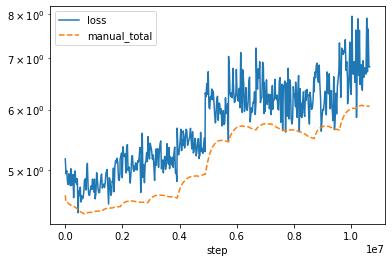

In [18]:
loss_components = [
    "p0loss_1",
    "p1loss_1",
    "vloss_1",
    "tdvloss_1",
    "tdsloss_1",
    "smloss_1",
    "leadloss_1",
    "vtimeloss_1",
    "sbpdfloss_1",
    "sbcdfloss_1",
    "oloss_1",
    "sloss_1",
    "fploss_1",
    "skloss_1",
    "rsdloss_1",
    "evstloss_1",
    "esstloss_1",
    "rloss_1",
    "rscloss_1",
]
print("Not present losses:", [k for k in loss_components if k not in tb_metric_dict])

tb_metric_dict["loss"].plot()

tot = sum(tb_metric_dict[k] for k in loss_components if k in tb_metric_dict)
tot.name ="manual_total"
tot.plot(linestyle="--")
plt.yscale("log")

plt.legend();

### Parse games

In [20]:
random.seed(42)
game_infos: List[game_info.GameInfo] = process_map(
    game_info.parse_game_info,
    raw_sgf_strs,
    max_workers=64,
    chunksize=50,
)

  0%|          | 0/21398 [00:00<?, ?it/s]

In [21]:
%%time
df = pd.DataFrame([gi.to_dict() for gi in game_infos])
print("gtypes:", df.gtype.unique())
print("Number of cleanup games:", (df.gtype == "cleanuptraining").sum())

# Filter to only normal games
df = df[(df.gtype == "normal")]
print("Fraction continuation:    ", df.is_continuation.mean())
print("Fraction used_initial_pos:", df.used_initial_position.mean())
print("max(init_turn_num)       :", df.init_turn_num.max())

df.head()

gtypes: ['normal']
Number of cleanup games: 0
Fraction continuation:     0.0
Fraction used_initial_pos: 0.0
max(init_turn_num)       : 0
CPU times: user 914 ms, sys: 13 ms, total: 927 ms
Wall time: 926 ms


,board_size,gtype,start_turn_idx,init_turn_num,used_initial_position,b_name,w_name,win_color,komi,handicap,...,fpok,sgf_str,victim_color,adv_color,adv_name,adv_steps,adv_win,adv_minus_victim_score,adv_komi,adv_minus_victim_score_wo_komi
0,7,normal,0,0,False,t0-s5715456-d1287763,victim,b,6.5,0,...,False,(;FF[4]GM[1]SZ[7]PB[t0-s5715456-d1287763]PW[vi...,w,b,t0-s5715456-d1287763,5715456,True,2.5,-6.5,9.0
1,7,normal,0,0,False,victim,t0-s5715456-d1287763,b,6.5,0,...,False,(;FF[4]GM[1]SZ[7]PB[victim]PW[t0-s5715456-d128...,b,w,t0-s5715456-d1287763,5715456,False,-2.5,6.5,-9.0
2,7,normal,0,0,False,t0-s5715456-d1287763,victim,b,6.5,0,...,False,(;FF[4]GM[1]SZ[7]PB[t0-s5715456-d1287763]PW[vi...,w,b,t0-s5715456-d1287763,5715456,True,2.5,-6.5,9.0
3,7,normal,0,0,False,victim,t0-s5715456-d1287763,b,6.5,0,...,False,(;FF[4]GM[1]SZ[7]PB[victim]PW[t0-s5715456-d128...,b,w,t0-s5715456-d1287763,5715456,False,-2.5,6.5,-9.0
4,7,normal,0,0,False,victim,t0-s5715456-d1287763,b,6.5,0,...,False,(;FF[4]GM[1]SZ[7]PB[victim]PW[t0-s5715456-d128...,b,w,t0-s5715456-d1287763,5715456,False,-2.5,6.5,-9.0


In [22]:
# Fix warmstart checkpoint
# df.loc[df.adv_steps == 111258368, 'adv_steps'] = 0

In [23]:
df.board_size.unique()

array([ 7,  8, 10,  9, 11, 13, 12, 14, 15, 16, 17, 19, 18])

In [24]:
df19 = df[df.board_size == 19]
# df19 = df
df19.head()

,board_size,gtype,start_turn_idx,init_turn_num,used_initial_position,b_name,w_name,win_color,komi,handicap,...,fpok,sgf_str,victim_color,adv_color,adv_name,adv_steps,adv_win,adv_minus_victim_score,adv_komi,adv_minus_victim_score_wo_komi
658,19,normal,0,0,False,victim,t0-s5715456-d1287763,b,6.5,0,...,False,(;FF[4]GM[1]SZ[19]PB[victim]PW[t0-s5715456-d12...,b,w,t0-s5715456-d1287763,5715456,False,-8.5,6.5,-15.0
779,19,normal,0,0,False,t0-s5715456-d1287763,victim,w,6.5,0,...,False,(;FF[4]GM[1]SZ[19]PB[t0-s5715456-d1287763]PW[v...,w,b,t0-s5715456-d1287763,5715456,False,-5.5,-6.5,1.0
801,19,normal,0,0,False,victim,t0-s5715456-d1287763,b,6.5,0,...,False,(;FF[4]GM[1]SZ[19]PB[victim]PW[t0-s5715456-d12...,b,w,t0-s5715456-d1287763,5715456,False,-38.5,6.5,-45.0
807,19,normal,0,0,False,t0-s5715456-d1287763,victim,w,6.5,0,...,False,(;FF[4]GM[1]SZ[19]PB[t0-s5715456-d1287763]PW[v...,w,b,t0-s5715456-d1287763,5715456,False,-1.5,-6.5,5.0
826,19,normal,0,0,False,victim,t0-s5715456-d1287763,w,6.5,0,...,False,(;FF[4]GM[1]SZ[19]PB[victim]PW[t0-s5715456-d12...,b,w,t0-s5715456-d1287763,5715456,True,0.5,6.5,-6.0


### Analyze data

In [25]:
def hist_3d(
    df: pd.DataFrame,
    t_key: str,
    ts: np.ndarray,
    v_key: str,
    ax: plt.Axes,
    cmap: plt.cm.ScalarMappable = plt.cm.inferno,
    bins: int = 50,
):
    """Adapted from https://stackoverflow.com/a/65126279/1337463"""
    ts = np.sort(ts)
    if len(ts) > 2:  # truncate early points which are unreliable
        ts = ts[2:]

    # calculate now the histogram and plot it for each column
    for i, t in enumerate(ts): # type: ignore
        # extract the current column from your df by its number
        col = df[df[t_key] == t][v_key]

        # determine the histogram values, here you have to adapt it to your needs
        histvals, edges = np.histogram(col, bins=bins, density=True)

        # calculate the center and width of each bar
        # obviously not necessary to do this for each column if you always have the same bins
        # but if you choose for np.histogram other parameters, the bins may not be the same for each histogram
        xcenter = np.convolve(edges, np.ones(2), "valid") / 2
        xwidth = np.diff(edges)

        # plot the histogram as a bar for each bin
        # now with continuous color mapping and edgecolor, so we can better see all bars
        ax.bar(
            left=xcenter,
            height=histvals,
            width=xwidth,
            zs=t,
            zdir="y",
            color=cmap(1 - i / len(ts)), # type: ignore
            alpha=0.666,
            edgecolor="grey",
        ) # type: ignore

    ax.set_xlabel(v_key)
    ax.set_ylabel(t_key)
    ax.set_zlabel("density")

    ax.set_ylim(ts[-1], ts[0])
    ax.set_yticks(ts[::10])

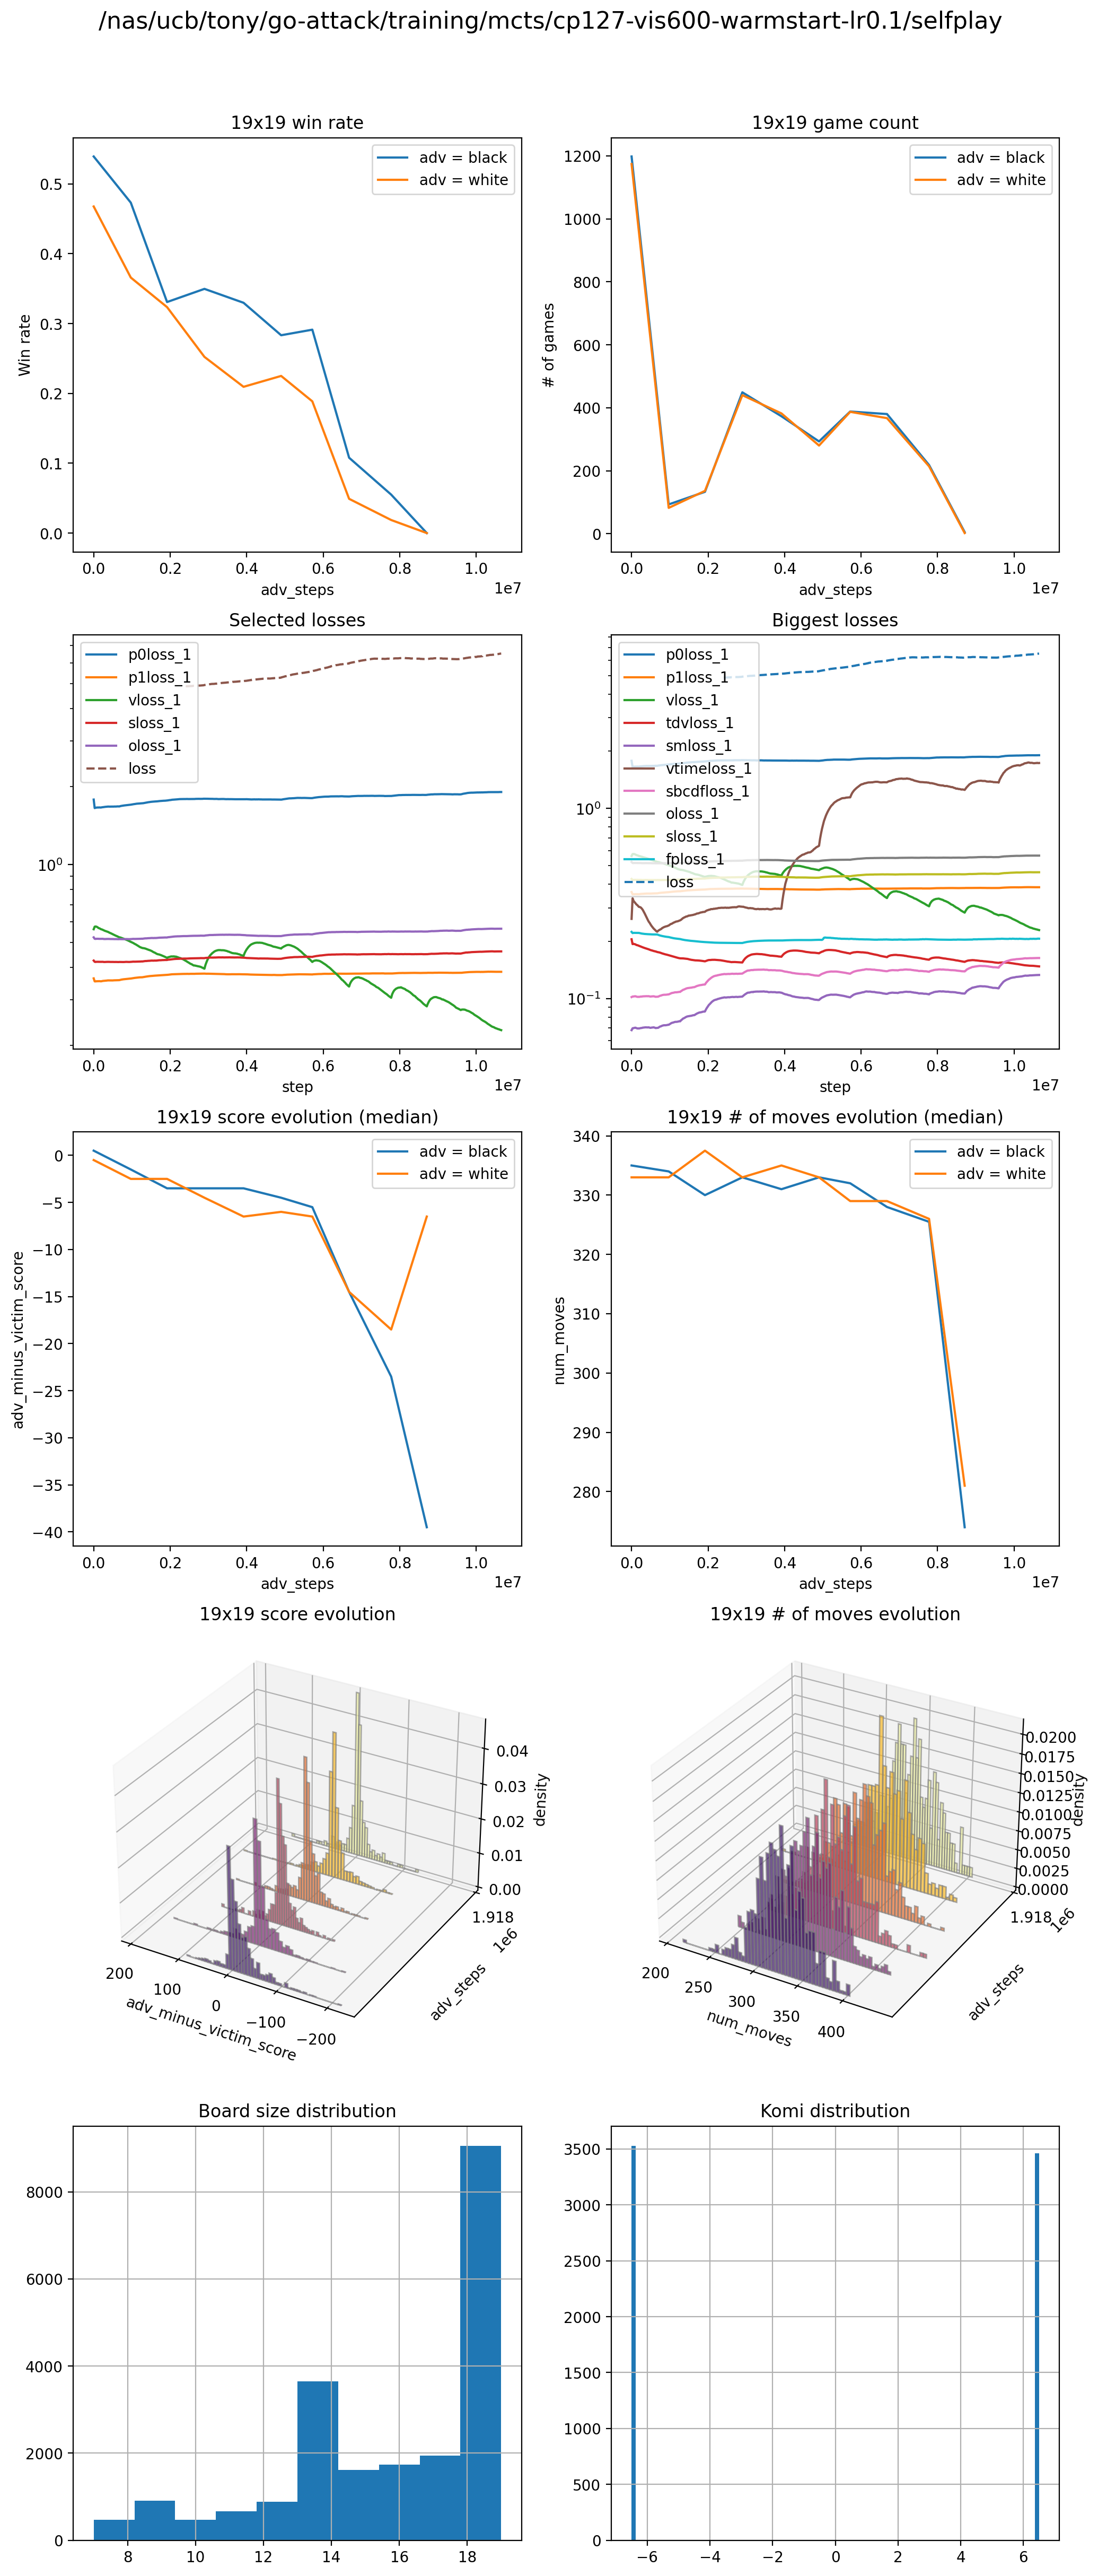

In [27]:
sz_prefix = "19x19 "
# sz_prefix = ""

nrows, ncols = 5, 2
cur_plot_idx = 0
def next_plot_idx():
    global cur_plot_idx
    cur_plot_idx += 1
    return cur_plot_idx

def set_plot_lims():
    plt.xlim(-0.05 * df_tb.step.max(), 1.05 * df_tb.step.max())
    

plt.figure(figsize=(ncols * 6, nrows * 6), dpi=200)
plt.suptitle(SELFPLAY_DIR, fontsize=16, y=0.92)

plt.subplot(nrows, ncols, next_plot_idx())
df19[df19.adv_color == "b"].groupby("adv_steps").mean().adv_win.plot(
    label="adv = black"
)
df19[df19.adv_color == "w"].groupby("adv_steps").mean().adv_win.plot(
    label="adv = white"
)
plt.ylabel("Win rate")
plt.title(sz_prefix + "win rate")
set_plot_lims()
plt.legend()

plt.subplot(nrows, ncols, next_plot_idx())
df19[df19.adv_color == "b"].groupby("adv_steps").count().adv_win.plot(
    label="adv = black"
)
df19[df19.adv_color == "w"].groupby("adv_steps").count().adv_win.plot(
    label="adv = white"
)
plt.ylabel("# of games")
plt.title(sz_prefix + "game count")
set_plot_lims()
plt.legend()

plt.subplot(nrows, ncols, next_plot_idx())
for k in ["p0loss_1", "p1loss_1", "vloss_1", "sloss_1", "oloss_1"]:
    tb_metric_dict[k].plot()
tb_metric_dict["loss"].rolling(100).mean().plot(linestyle="--")
plt.legend()
plt.yscale("log")
plt.title("Selected losses");

plt.subplot(nrows, ncols, next_plot_idx())
for k in loss_components:
    if k not in tb_metric_dict:
        continue
    if tb_metric_dict[k].iloc[-1] < 1e-2 * tb_metric_dict["loss"].iloc[-1]:
        continue
    tb_metric_dict[k].plot()
tb_metric_dict["loss"].rolling(100).mean().plot(linestyle="--")
plt.legend()
plt.yscale("log")
plt.title("Biggest losses");

plt.subplot(nrows, ncols, next_plot_idx())
df19[df19.adv_color == "b"].groupby("adv_steps").median().adv_minus_victim_score.plot(
    label="adv = black"
)
df19[df19.adv_color == "w"].groupby("adv_steps").median().adv_minus_victim_score.plot(
    label="adv = white"
)
plt.ylabel("adv_minus_victim_score")
plt.title(sz_prefix + "score evolution (median)")
set_plot_lims()
plt.legend()

plt.subplot(nrows, ncols, next_plot_idx())
df19[df19.adv_color == "b"].groupby("adv_steps").median().num_moves.plot(
    label="adv = black"
)
df19[df19.adv_color == "w"].groupby("adv_steps").median().num_moves.plot(
    label="adv = white"
)
plt.ylabel("num_moves")
plt.title(sz_prefix + "# of moves evolution (median)")
set_plot_lims()
plt.legend()

ax = plt.subplot(nrows, ncols, next_plot_idx(), projection="3d")
hist_3d(
    df19,
    ts=np.sort(df19.adv_steps.unique())[:-2],
    t_key="adv_steps",
    v_key="adv_minus_victim_score",
    ax=ax,
)
ax.invert_xaxis()
plt.title(sz_prefix + "score evolution")

ax = plt.subplot(nrows, ncols, next_plot_idx(), projection="3d")
hist_3d(
    df19,
    ts=np.sort(df19.adv_steps.unique())[:-2],
    t_key="adv_steps",
    v_key="num_moves",
    ax=ax,
)
plt.title(sz_prefix + "# of moves evolution")

plt.subplot(nrows, ncols, next_plot_idx())
df.board_size.hist()
plt.title("Board size distribution")

plt.subplot(nrows, ncols, next_plot_idx())
df19.adv_komi.hist(bins=100)
plt.title("Komi distribution");

### Games

In [10]:
def sgf_str_to_url(sgf_str: str) -> str:
    return f"https://humancompatibleai.github.io/sgf-viewer/#sgf={sgf_str}"


@dataclasses.dataclass(frozen=True)
class Url:
    """Wrapper around a URL string to provide nice display in IPython environments."""

    url: str
    text: str

    def _repr_html_(self):
        """HTML link to this URL."""
        return f'<a href="{self.url}">{self.text}</a>'

    def __str__(self):
        """Return the underlying string."""
        return self.url

In [11]:
ADV_STEPS = list(sorted(df19.adv_steps.unique()))
ADV_STEP_VIZ = ADV_STEPS[-3] if len(ADV_STEPS) > 3 else ADV_STEPS[0]
print(ADV_STEP_VIZ)

df_win = df19[(df19.adv_steps == ADV_STEP_VIZ) & df19.adv_win]
print(df_win.adv_color.unique())

df_loss = df19[(df19.adv_steps == ADV_STEP_VIZ) & ~df19.adv_win]
print(df_loss.adv_color.unique())

9454336
[]
['b' 'w']


Text(0.5, 1.0, 'Adv. losses')

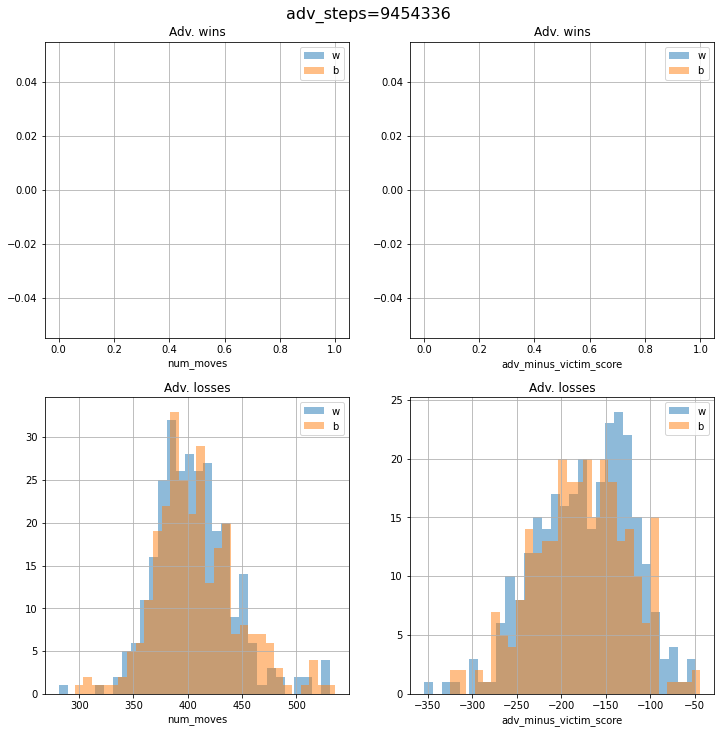

In [12]:
plt.figure(figsize=(12, 12))
plt.suptitle(f"adv_steps={ADV_STEP_VIZ}", fontsize=16, y=0.92)

plt.subplot(2, 2, 1)
df_win[df_win.adv_color == "w"].num_moves.hist(bins=30, label="w", alpha=0.5)
df_win[df_win.adv_color == "b"].num_moves.hist(bins=30, label="b", alpha=0.5)
plt.legend()
plt.xlabel("num_moves")
plt.title("Adv. wins")

plt.subplot(2, 2, 2)
df_win[df_win.adv_color == "w"].adv_minus_victim_score.hist(
    bins=30, label="w", alpha=0.5
)
df_win[df_win.adv_color == "b"].adv_minus_victim_score.hist(
    bins=30, label="b", alpha=0.5
)
plt.legend()
plt.xlabel("adv_minus_victim_score")
plt.title("Adv. wins")

plt.subplot(2, 2, 3)
df_loss[df_loss.adv_color == "w"].num_moves.hist(bins=30, label="w", alpha=0.5)
df_loss[df_loss.adv_color == "b"].num_moves.hist(bins=30, label="b", alpha=0.5)
plt.legend()
plt.xlabel("num_moves")
plt.title("Adv. losses")

plt.subplot(2, 2, 4)
df_loss[df_loss.adv_color == "w"].adv_minus_victim_score.hist(
    bins=30, label="w", alpha=0.5
)
df_loss[df_loss.adv_color == "b"].adv_minus_victim_score.hist(
    bins=30, label="b", alpha=0.5
)
plt.legend()
plt.xlabel("adv_minus_victim_score")
plt.title("Adv. losses")

In [13]:
for df_cur, lab in [(df_win, "win"), (df_loss, "loss")]:
    for color in ["b", "w"]:
        dfc = df_cur[df_cur.adv_color == color]
        for i in range(min(2, len(dfc))):
            display(
                Url(
                    url=sgf_str_to_url(
                        dfc.sgf_str.iloc[i]
                    ),
                    text=f"{color}_{lab}{i}={ADV_STEP_VIZ}",
                )
            )

Url(url='https://humancompatibleai.github.io/sgf-viewer/#sgf=(;FF[4]GM[1]SZ[19]PB[t0-s9454336-d2291738]PW[victim]HA[0]KM[6.5]RU[koPOSITIONALscoreAREAtaxNONEsui1]RE[W+61.5]C[startTurnIdx=0,initTurnNum=0,gameHash=C194259421E05B959D7267C6B52B9DA8,gtype=normal];B[pd]C[0.51 0.49 0.00 0.4 v=600 weight=1.37];W[dp]C[0.42 0.58 0.00 -1.1 v=600 weight=0.62];B[cq]C[0.51 0.49 0.00 1.7 v=600 weight=1.22];W[cp]C[0.43 0.57 0.00 -1.0 v=600 weight=0.60];B[dq]C[0.50 0.50 0.00 2.0 v=600 weight=0.80];W[fq]C[0.42 0.58 0.00 -1.1 v=600 weight=0.61];B[fr]C[0.50 0.50 0.00 1.6 v=600 weight=0.78];W[pp]C[0.42 0.58 0.00 -1.3 v=600 weight=0.89];B[gq]C[0.50 0.50 0.00 2.0 v=600 weight=1.11];W[fp]C[0.48 0.52 0.00 0.1 v=600 weight=0.71];B[hr]C[0.50 0.50 0.00 0.7 v=600 weight=0.98];W[dc]C[0.51 0.49 0.00 0.7 v=600 weight=0.88];B[ce]C[0.51 0.49 0.00 3.1 v=600 weight=1.10];W[fd]C[0.51 0.49 0.00 0.7 v=600 weight=0.82];B[qn]C[0.50 0.50 0.00 1.5 v=600 weight=1.39];W[qc]C[0.55 0.45 0.00 1.4 v=600 weight=0.79];B[gp]C[0.51 0.49 0.00 2.6 v=600 weight=1.56];W[pc]C[0.64 0.36 0.00 3.4 v=600 weight=0.66];B[od]C[0.50 0.50 0.00 0.7 v=600 weight=0.94];W[oc]C[0.64 0.36 0.00 3.5 v=600 weight=0.66];B[nd]C[0.50 0.50 0.00 -0.6 v=600 weight=0.93];W[re]C[0.64 0.36 0.00 3.5 v=600 weight=0.73];B[dn]C[0.50 0.50 0.00 -1.9 v=600 weight=1.67];W[bo]C[0.70 0.30 0.00 5.0 v=600 weight=0.86];B[cm]C[0.51 0.49 0.00 0.3 v=600 weight=0.99];W[bm]C[0.76 0.24 0.00 6.2 v=600 weight=1.03];B[bn]C[0.50 0.50 0.00 1.1 v=600 weight=1.53];W[an]C[0.68 0.32 0.00 4.4 v=600 weight=0.65];B[cn]C[0.50 0.50 0.00 0.6 v=600 weight=0.83];W[bl]C[0.68 0.32 0.00 4.2 v=600 weight=0.69];B[ck]C[0.50 0.50 0.00 0.6 v=600 weight=1.30];W[bk]C[0.68 0.32 0.00 4.4 v=600 weight=0.87];B[cj]C[0.50 0.50 0.00 0.5 v=600 weight=0.91];W[bj]C[0.68 0.32 0.00 4.2 v=600 weight=0.86];B[ci]C[0.50 0.50 0.00 -0.1 v=600 weight=0.89];W[bq]C[0.66 0.34 0.00 3.9 v=600 weight=0.90];B[br]C[0.50 0.50 0.00 -0.5 v=600 weight=0.89];W[ar]C[0.66 0.34 0.00 3.9 v=600 weight=1.10];B[cr]C[0.50 0.50 0.00 0.2 v=600 weight=1.02];W[bi]C[0.65 0.35 0.00 3.4 v=600 weight=0.94];B[bh]C[0.50 0.50 0.00 -0.2 v=600 weight=1.13];W[cl]C[0.85 0.15 0.00 9.4 v=600 weight=1.01];B[dl]C[0.50 0.50 0.00 2.2 v=600 weight=0.88];W[en]C[0.83 0.17 0.00 9.2 v=600 weight=0.89];B[go]C[0.51 0.49 0.00 2.5 v=600 weight=1.76];W[em]C[0.90 0.10 0.00 13.3 v=600 weight=1.14];B[dm]C[0.51 0.49 0.00 4.7 v=600 weight=0.70];W[eq]C[0.91 0.09 0.00 12.6 v=600 weight=1.81];B[er]C[0.51 0.49 0.00 2.6 v=600 weight=0.77];W[fo]C[0.92 0.08 0.00 12.4 v=600 weight=0.71];B[fk]C[0.51 0.49 0.00 0.7 v=600 weight=1.05];W[ch]C[0.95 0.05 0.00 13.7 v=600 weight=0.77];B[dh]C[0.50 0.50 0.00 3.0 v=600 weight=0.97];W[cg]C[0.96 0.04 0.00 16.9 v=600 weight=0.66];B[bg]C[0.51 0.49 0.00 3.2 v=600 weight=0.81];W[dg]C[0.96 0.04 0.00 17.3 v=600 weight=0.72];B[eg]C[0.50 0.50 0.00 5.8 v=600 weight=0.82];W[df]C[0.96 0.04 0.00 17.4 v=600 weight=0.95];B[ed]C[0.51 0.49 0.00 6.0 v=600 weight=0.87];W[ec]C[0.97 0.03 0.00 17.9 v=600 weight=0.86];B[ee]C[0.51 0.49 0.00 7.8 v=600 weight=0.88];W[eh]C[0.97 0.03 0.00 19.2 v=600 weight=1.02];B[ef]C[0.51 0.49 0.00 6.8 v=600 weight=1.59];W[di]C[0.97 0.03 0.00 21.9 v=600 weight=0.74];B[ej]C[0.50 0.50 0.00 6.6 v=600 weight=0.86];W[bf]C[0.98 0.02 0.00 21.7 v=600 weight=0.81];B[fh]C[0.51 0.49 0.00 10.5 v=600 weight=0.90];W[hd]C[0.99 0.01 0.00 21.9 v=600 weight=0.62];B[np]C[0.50 0.50 0.00 10.9 v=600 weight=1.73];W[nq]C[0.99 0.01 0.00 22.3 v=600 weight=0.66];B[mq]C[0.51 0.49 0.00 12.0 v=600 weight=0.93];W[oq]C[0.99 0.01 0.00 22.7 v=600 weight=0.71];B[mp]C[0.51 0.49 0.00 13.2 v=600 weight=0.87];W[rp]C[1.00 0.00 0.00 22.6 v=600 weight=0.68];B[ro]C[0.51 0.49 0.00 13.7 v=600 weight=1.48];W[qo]C[1.00 0.00 0.00 23.9 v=600 weight=0.74];B[pn]C[0.52 0.48 0.00 15.0 v=600 weight=0.93];W[rn]C[1.00 0.00 0.00 23.7 v=600 weight=0.62];B[id]C[0.51 0.49 0.00 14.3 v=600 weight=1.67];W[he]C[1.00 0.00 0.00 23.7 v=600 weight=0.76];B[ie]C[0.51 0.49 0.00 14.5 v=600 weight=1.17];W[hg]C[1.00 0.00 0.00 24.5 v=600 weight=0.79];B[ih]C[0.51 0.49

Url(url='https://humancompatibleai.github.io/sgf-viewer/#sgf=(;FF[4]GM[1]SZ[19]PB[t0-s9454336-d2291738]PW[victim]HA[0]KM[6.5]RU[koPOSITIONALscoreAREAtaxNONEsui1]RE[W+79.5]C[startTurnIdx=0,initTurnNum=0,gameHash=230039F76DE826ADEA58E768AA69D5A7,gtype=normal];B[dp]C[0.50 0.50 0.00 -0.3 v=600 weight=1.98];W[pp]C[0.43 0.57 0.00 -1.0 v=600 weight=0.73];B[mm]C[0.52 0.48 0.00 2.0 v=600 weight=1.53];W[pd]C[0.51 0.49 0.00 0.6 v=600 weight=0.78];B[dd]C[0.51 0.49 0.00 2.7 v=600 weight=2.12];W[cc]C[0.51 0.49 0.00 0.6 v=600 weight=0.84];B[cd]C[0.50 0.50 0.00 -1.5 v=600 weight=1.14];W[dc]C[0.50 0.50 0.00 0.5 v=600 weight=0.74];B[ed]C[0.50 0.50 0.00 -2.0 v=600 weight=0.99];W[ec]C[0.51 0.49 0.00 0.6 v=600 weight=0.94];B[fc]C[0.50 0.50 0.00 -2.6 v=600 weight=1.35];W[fb]C[0.50 0.50 0.00 0.5 v=600 weight=0.75];B[qq]C[0.50 0.50 0.00 -3.6 v=600 weight=1.56];W[pq]C[0.51 0.49 0.00 0.6 v=600 weight=0.92];B[qp]C[0.51 0.49 0.00 -1.8 v=600 weight=1.01];W[qo]C[0.51 0.49 0.00 0.6 v=600 weight=0.88];B[ro]C[0.50 0.50 0.00 -4.6 v=600 weight=1.02];W[rn]C[0.52 0.48 0.00 0.8 v=600 weight=0.76];B[qn]C[0.50 0.50 0.00 -4.0 v=600 weight=1.02];W[po]C[0.52 0.48 0.00 0.5 v=600 weight=0.66];B[rm]C[0.50 0.50 0.00 -4.7 v=600 weight=0.96];W[rp]C[0.52 0.48 0.00 0.7 v=600 weight=0.76];B[sn]C[0.50 0.50 0.00 -4.3 v=600 weight=1.00];W[rq]C[0.51 0.49 0.00 0.4 v=600 weight=0.74];B[qc]C[0.50 0.50 0.00 -5.1 v=600 weight=1.62];W[pc]C[0.54 0.46 0.00 1.0 v=600 weight=0.73];B[qd]C[0.50 0.50 0.00 -3.2 v=600 weight=1.06];W[qe]C[0.54 0.46 0.00 1.0 v=600 weight=0.76];B[re]C[0.50 0.50 0.00 -5.2 v=600 weight=1.15];W[rf]C[0.54 0.46 0.00 1.1 v=600 weight=0.75];B[qf]C[0.50 0.50 0.00 -4.9 v=600 weight=1.15];W[pe]C[0.54 0.46 0.00 0.8 v=600 weight=0.72];B[rg]C[0.50 0.50 0.00 -4.4 v=600 weight=1.11];W[rd]C[0.54 0.46 0.00 1.1 v=600 weight=0.74];B[sf]C[0.50 0.50 0.00 -4.0 v=600 weight=1.10];W[rc]C[0.53 0.47 0.00 0.9 v=600 weight=0.74];B[cn]C[0.50 0.50 0.00 -4.9 v=600 weight=2.39];W[gc]C[0.58 0.42 0.00 2.0 v=600 weight=0.83];B[fd]C[0.50 0.50 0.00 -1.7 v=600 weight=1.18];W[bc]C[0.58 0.42 0.00 2.0 v=600 weight=0.75];B[he]C[0.50 0.50 0.00 -1.4 v=600 weight=2.61];W[og]C[0.63 0.37 0.00 3.1 v=600 weight=1.01];B[pi]C[0.50 0.50 0.00 -1.3 v=600 weight=2.49];W[er]C[0.71 0.29 0.00 4.4 v=600 weight=1.13];B[dq]C[0.50 0.50 0.00 -0.5 v=600 weight=2.54];W[hq]C[0.74 0.26 0.00 5.0 v=600 weight=0.76];B[hc]C[0.50 0.50 0.00 -1.2 v=600 weight=2.16];W[gb]C[0.80 0.20 0.00 6.5 v=600 weight=0.76];B[jq]C[0.50 0.50 0.00 -2.0 v=600 weight=2.59];W[fq]C[0.81 0.19 0.00 6.8 v=600 weight=1.02];B[gp]C[0.50 0.50 0.00 -1.7 v=600 weight=1.76];W[hp]C[0.84 0.16 0.00 7.8 v=600 weight=1.24];B[hg]C[0.50 0.50 0.00 -0.7 v=600 weight=2.82];W[go]C[0.91 0.09 0.00 10.1 v=600 weight=1.13];B[bd]C[0.50 0.50 0.00 -0.0 v=600 weight=2.42];W[dk]C[0.95 0.05 0.00 11.6 v=600 weight=1.24];B[ci]C[0.51 0.49 0.00 1.8 v=600 weight=2.67];W[dm]C[0.95 0.05 0.00 11.8 v=600 weight=0.90];B[fo]C[0.51 0.49 0.00 2.2 v=600 weight=2.68];W[dn]C[0.95 0.05 0.00 12.1 v=600 weight=1.45];B[do]C[0.51 0.49 0.00 3.6 v=600 weight=1.17];W[cm]C[0.95 0.05 0.00 12.4 v=600 weight=0.85];B[nr]C[0.51 0.49 0.00 2.6 v=600 weight=1.46];W[or]C[0.95 0.05 0.00 12.6 v=600 weight=0.85];B[bn]C[0.51 0.49 0.00 4.5 v=600 weight=1.08];W[fn]C[0.96 0.04 0.00 13.0 v=600 weight=0.97];B[gd]C[0.51 0.49 0.00 2.6 v=600 weight=2.63];W[eo]C[0.99 0.01 0.00 16.6 v=600 weight=0.87];B[dr]C[0.53 0.47 0.00 7.8 v=600 weight=1.76];W[om]C[0.99 0.01 0.00 16.4 v=600 weight=0.81];B[ol]C[0.56 0.44 0.00 10.7 v=600 weight=2.32];W[pl]C[0.99 0.01 0.00 16.9 v=600 weight=0.81];B[pm]C[0.56 0.44 0.00 10.4 v=600 weight=1.34];W[pn]C[0.99 0.01 0.00 16.6 v=600 weight=0.81];B[qm]C[0.56 0.44 0.00 10.7 v=600 weight=1.10];W[nl]C[0.99 0.01 0.00 16.3 v=600 weight=0.82];B[ok]C[0.55 0.45 0.00 9.9 v=600 weight=1.08];W[nm]C[0.99 0.01 0.00 16.1 v=600 weight=0.88];B[mq]C[0.56 0.44 0.00 10.7 v=600 weight=1.83];W[oj]C[0.99 0.01 0.00 15.9 v=600 weight=0.89];B[pj]C[0.55 0.45 0.00 10.3 v=600 weight=1.66];W[nk]C[0.99 0.01 0.00 15.9 v=600 weight=0.83];B[pk]

Url(url='https://humancompatibleai.github.io/sgf-viewer/#sgf=(;FF[4]GM[1]SZ[19]PB[victim]PW[t0-s9454336-d2291738]HA[0]KM[6.5]RU[koPOSITIONALscoreAREAtaxNONEsui1]RE[B+88.5]C[startTurnIdx=0,initTurnNum=0,gameHash=4DFD3E9BA022787CDC0F129F6F08F254,gtype=normal];B[pd]C[0.46 0.54 0.00 -0.3 v=600 weight=0.78];W[pp]C[0.50 0.50 0.00 0.4 v=600 weight=1.43];B[qq]C[0.45 0.55 0.00 -0.5 v=600 weight=0.79];W[qp]C[0.49 0.51 0.00 0.3 v=600 weight=1.54];B[pq]C[0.46 0.54 0.00 -0.3 v=600 weight=0.80];W[op]C[0.50 0.50 0.00 1.1 v=600 weight=0.99];B[nr]C[0.46 0.54 0.00 -0.4 v=600 weight=0.83];W[dd]C[0.50 0.50 0.00 0.3 v=600 weight=1.29];B[dp]C[0.45 0.55 0.00 -0.5 v=600 weight=0.69];W[qc]C[0.50 0.50 0.00 -1.2 v=600 weight=1.29];B[qd]C[0.45 0.55 0.00 -0.7 v=600 weight=0.74];W[pc]C[0.50 0.50 0.00 -1.1 v=600 weight=1.01];B[od]C[0.45 0.55 0.00 -0.7 v=600 weight=0.70];W[oc]C[0.49 0.51 0.00 -1.4 v=600 weight=1.30];B[nc]C[0.45 0.55 0.00 -0.7 v=600 weight=0.74];W[nb]C[0.49 0.51 0.00 -3.0 v=600 weight=1.06];B[cc]C[0.44 0.56 0.00 -0.9 v=600 weight=0.77];W[cd]C[0.49 0.51 0.00 -2.4 v=600 weight=1.04];B[dc]C[0.45 0.55 0.00 -0.6 v=600 weight=0.75];W[fc]C[0.49 0.51 0.00 -3.5 v=600 weight=0.95];B[ec]C[0.45 0.55 0.00 -0.5 v=600 weight=0.73];W[ed]C[0.49 0.51 0.00 -4.1 v=600 weight=1.02];B[fb]C[0.45 0.55 0.00 -0.5 v=600 weight=0.75];W[cq]C[0.48 0.52 0.00 -2.5 v=600 weight=1.24];B[dq]C[0.44 0.56 0.00 -0.8 v=600 weight=0.81];W[cp]C[0.49 0.51 0.00 -2.4 v=600 weight=1.01];B[cn]C[0.44 0.56 0.00 -0.7 v=600 weight=0.74];W[nq]C[0.49 0.51 0.00 -2.9 v=600 weight=1.64];B[mq]C[0.43 0.57 0.00 -0.9 v=600 weight=1.08];W[mp]C[0.49 0.51 0.00 -4.1 v=600 weight=1.17];B[lq]C[0.43 0.57 0.00 -1.0 v=600 weight=0.97];W[or]C[0.49 0.51 0.00 -3.2 v=600 weight=1.39];B[oq]C[0.41 0.59 0.00 -1.2 v=600 weight=0.72];W[np]C[0.49 0.51 0.00 -6.3 v=600 weight=1.56];B[pr]C[0.41 0.59 0.00 -1.2 v=600 weight=0.85];W[nl]C[0.49 0.51 0.00 -5.1 v=600 weight=2.45];B[co]C[0.22 0.78 0.00 -5.2 v=600 weight=0.70];W[qh]C[0.49 0.51 0.00 -2.9 v=600 weight=1.98];B[rc]C[0.19 0.81 0.00 -6.4 v=600 weight=0.94];W[hc]C[0.49 0.51 0.00 -5.6 v=600 weight=1.67];B[mb]C[0.08 0.92 0.00 -10.5 v=600 weight=0.87];W[mc]C[0.49 0.51 0.00 -5.9 v=600 weight=1.13];B[nd]C[0.07 0.93 0.00 -10.5 v=600 weight=0.72];W[lb]C[0.49 0.51 0.00 -7.1 v=600 weight=1.09];B[ob]C[0.08 0.92 0.00 -10.3 v=600 weight=0.99];W[ma]C[0.49 0.51 0.00 -8.1 v=600 weight=0.90];B[qb]C[0.07 0.93 0.00 -10.4 v=600 weight=0.83];W[eo]C[0.50 0.50 0.00 -7.6 v=600 weight=2.57];B[gc]C[0.04 0.96 0.00 -13.8 v=600 weight=0.85];W[fd]C[0.49 0.51 0.00 -8.5 v=600 weight=0.99];B[gd]C[0.04 0.96 0.00 -14.3 v=600 weight=0.84];W[do]C[0.49 0.51 0.00 -10.5 v=600 weight=1.12];B[cr]C[0.03 0.97 0.00 -15.6 v=600 weight=0.87];W[pj]C[0.49 0.51 0.00 -11.7 v=600 weight=2.20];B[hb]C[0.02 0.98 0.00 -16.4 v=600 weight=0.77];W[ge]C[0.49 0.51 0.00 -11.6 v=600 weight=1.21];B[hd]C[0.01 0.99 0.00 -16.1 v=600 weight=0.79];W[he]C[0.49 0.51 0.00 -11.5 v=600 weight=1.11];B[dk]C[0.01 0.99 0.00 -16.9 v=600 weight=0.76];W[dj]C[0.49 0.51 0.00 -10.9 v=600 weight=1.98];B[ck]C[0.01 0.99 0.00 -17.2 v=600 weight=0.93];W[dm]C[0.48 0.52 0.00 -13.0 v=600 weight=1.57];B[bq]C[0.01 0.99 0.00 -17.5 v=600 weight=1.21];W[ek]C[0.49 0.51 0.00 -14.0 v=600 weight=1.39];B[cj]C[0.01 0.99 0.00 -16.4 v=600 weight=0.84];W[jj]C[0.49 0.51 0.00 -17.0 v=600 weight=2.25];B[el]C[0.01 0.99 0.00 -18.3 v=600 weight=0.84];W[fl]C[0.48 0.52 0.00 -17.6 v=600 weight=2.00];B[em]C[0.01 0.99 0.00 -17.9 v=600 weight=0.86];W[mr]C[0.48 0.52 0.00 -18.6 v=600 weight=1.85];B[os]C[0.02 0.98 0.00 -17.7 v=600 weight=0.89];W[fm]C[0.48 0.52 0.00 -20.2 v=600 weight=1.22];B[fn]C[0.01 0.99 0.00 -17.8 v=600 weight=0.93];W[gn]C[0.48 0.52 0.00 -21.5 v=600 weight=1.20];B[en]C[0.01 0.99 0.00 -18.2 v=600 weight=0.95];W[go]C[0.47 0.53 0.00 -22.8 v=600 weight=1.37];B[kp]C[0.01 0.99 0.00 -18.3 v=600 weight=1.07];W[ko]C[0.47 0.53 0.00 -20.0 v=600 weight=1.88];B[fo]C[0.01 0.99 0.00 -17.8 v=600 weight=1.21];W[jp]C[0.47 0.53 0.00 -20.8 v=600 weight=1.50];B[fk]C[0.00 1.00 0.00 -17.9 v=6

Url(url='https://humancompatibleai.github.io/sgf-viewer/#sgf=(;FF[4]GM[1]SZ[19]PB[victim]PW[t0-s9454336-d2291738]HA[0]KM[6.5]RU[koPOSITIONALscoreAREAtaxNONEsui1]RE[B+56.5]C[startTurnIdx=0,initTurnNum=0,gameHash=D3DF6A015A57848A9664BE75D5280322,gtype=normal];B[dp]C[0.45 0.55 0.00 -0.4 v=600 weight=0.78];W[pd]C[0.50 0.50 0.00 0.0 v=600 weight=1.50];B[qc]C[0.45 0.55 0.00 -0.5 v=600 weight=0.86];W[pp]C[0.50 0.50 0.00 -0.3 v=600 weight=2.10];B[qd]C[0.44 0.56 0.00 -0.7 v=600 weight=0.81];W[pe]C[0.51 0.49 0.00 -0.7 v=600 weight=1.23];B[qe]C[0.44 0.56 0.00 -0.8 v=600 weight=1.02];W[pf]C[0.49 0.51 0.00 -1.3 v=600 weight=1.10];B[dd]C[0.43 0.57 0.00 -0.9 v=600 weight=1.17];W[cq]C[0.49 0.51 0.00 -4.5 v=600 weight=1.72];B[dq]C[0.42 0.58 0.00 -1.2 v=600 weight=0.73];W[cp]C[0.50 0.50 0.00 -3.3 v=600 weight=1.04];B[do]C[0.41 0.59 0.00 -1.2 v=600 weight=0.75];W[co]C[0.49 0.51 0.00 -4.1 v=600 weight=1.27];B[cn]C[0.40 0.60 0.00 -1.5 v=600 weight=0.88];W[bn]C[0.50 0.50 0.00 -5.8 v=600 weight=1.05];B[pc]C[0.40 0.60 0.00 -1.6 v=600 weight=0.77];W[nq]C[0.50 0.50 0.00 -6.8 v=600 weight=2.08];B[cr]C[0.38 0.62 0.00 -1.8 v=600 weight=1.24];W[br]C[0.49 0.51 0.00 -7.0 v=600 weight=1.34];B[bm]C[0.38 0.62 0.00 -1.9 v=600 weight=0.83];W[dr]C[0.49 0.51 0.00 -7.2 v=600 weight=1.74];B[dm]C[0.36 0.64 0.00 -2.2 v=600 weight=0.84];W[cc]C[0.50 0.50 0.00 -6.8 v=600 weight=1.90];B[cd]C[0.37 0.63 0.00 -2.1 v=600 weight=0.84];W[dc]C[0.50 0.50 0.00 -8.5 v=600 weight=1.07];B[ed]C[0.37 0.63 0.00 -2.0 v=600 weight=0.78];W[fc]C[0.50 0.50 0.00 -7.4 v=600 weight=1.70];B[ec]C[0.32 0.68 0.00 -3.0 v=600 weight=1.10];W[eb]C[0.49 0.51 0.00 -7.6 v=600 weight=0.93];B[bc]C[0.30 0.70 0.00 -3.4 v=600 weight=1.51];W[bb]C[0.49 0.51 0.00 -9.7 v=600 weight=2.12];B[fb]C[0.22 0.78 0.00 -5.7 v=600 weight=0.77];W[gb]C[0.50 0.50 0.00 -9.4 v=600 weight=1.98];B[db]C[0.06 0.94 0.00 -11.7 v=600 weight=0.89];W[fa]C[0.49 0.51 0.00 -10.3 v=600 weight=1.00];B[cb]C[0.07 0.93 0.00 -11.8 v=600 weight=0.82];W[nd]C[0.50 0.50 0.00 -7.5 v=600 weight=2.38];B[qg]C[0.05 0.95 0.00 -12.1 v=600 weight=0.90];W[ge]C[0.49 0.51 0.00 -7.5 v=600 weight=2.51];B[id]C[0.04 0.96 0.00 -12.5 v=600 weight=1.19];W[kd]C[0.49 0.51 0.00 -11.1 v=600 weight=1.98];B[hc]C[0.04 0.96 0.00 -12.7 v=600 weight=0.86];W[fd]C[0.49 0.51 0.00 -14.2 v=600 weight=1.36];B[if]C[0.04 0.96 0.00 -13.1 v=600 weight=0.77];W[hb]C[0.49 0.51 0.00 -13.9 v=600 weight=3.62];B[ib]C[0.02 0.98 0.00 -14.4 v=600 weight=0.79];W[gg]C[0.48 0.52 0.00 -17.0 v=600 weight=1.48];B[ih]C[0.02 0.98 0.00 -15.0 v=600 weight=0.73];W[kf]C[0.49 0.51 0.00 -16.2 v=600 weight=2.43];B[mc]C[0.02 0.98 0.00 -15.3 v=600 weight=0.87];W[nc]C[0.48 0.52 0.00 -15.7 v=600 weight=1.39];B[le]C[0.02 0.98 0.00 -15.0 v=600 weight=0.94];W[ke]C[0.49 0.51 0.00 -14.5 v=600 weight=1.21];B[lc]C[0.03 0.97 0.00 -14.7 v=600 weight=0.78];W[ld]C[0.48 0.52 0.00 -15.2 v=600 weight=1.48];B[md]C[0.02 0.98 0.00 -15.6 v=600 weight=1.06];W[me]C[0.49 0.51 0.00 -13.1 v=600 weight=1.08];B[ne]C[0.02 0.98 0.00 -16.1 v=600 weight=0.96];W[mf]C[0.48 0.52 0.00 -15.8 v=600 weight=1.07];B[nb]C[0.02 0.98 0.00 -16.7 v=600 weight=0.96];W[od]C[0.49 0.51 0.00 -14.3 v=600 weight=1.59];B[jc]C[0.01 0.99 0.00 -18.3 v=600 weight=1.00];W[eh]C[0.48 0.52 0.00 -16.9 v=600 weight=2.64];B[pg]C[0.01 0.99 0.00 -18.6 v=600 weight=0.99];W[og]C[0.47 0.53 0.00 -20.2 v=600 weight=1.20];B[lg]C[0.01 0.99 0.00 -18.3 v=600 weight=1.14];W[lf]C[0.47 0.53 0.00 -22.5 v=600 weight=1.34];B[oh]C[0.01 0.99 0.00 -18.2 v=600 weight=0.93];W[nh]C[0.46 0.54 0.00 -22.6 v=600 weight=2.27];B[of]C[0.01 0.99 0.00 -19.0 v=600 weight=1.53];W[ng]C[0.42 0.58 0.00 -19.7 v=600 weight=1.19];B[oc]C[0.01 0.99 0.00 -19.5 v=600 weight=0.99];W[nf]C[0.43 0.57 0.00 -17.8 v=600 weight=1.26];B[bo]C[0.00 1.00 0.00 -20.6 v=600 weight=0.93];W[bp]C[0.42 0.58 0.00 -17.0 v=600 weight=1.31];B[fh]C[0.00 1.00 0.00 -20.9 v=600 weight=0.83];W[fg]C[0.37 0.63 0.00 -20.0 v=600 weight=1.43];B[eg]C[0.00 1.00 0.00 -20.8 v=600 weight=1.00];W[ao]C[0.37 0.63 0.00 -20.3 v=600 weight=3.95];B[gh]C[0.00 1.00 0.